# LSTM Time Series Explorations with Keras

This is a very short exploration into applying LSTM techniques using the Keras library. Code and content is based on several cool blog posts and papers; see references section for more info.

There are further notes on LSTM theory and Keras in an accompanying Slideshare: https://www.slideshare.net/RalphSchlosser/lstm-tutorial

**FIXMEs**: 
* Compare and contrast different parametrizations or architectures.
* Consolidate helper functions, simplify.

## Exchange Rates Data
 
In this example we wish to make forcasts on a  time series of exchange rates.
 
The time series data forcast can be modeled as a univariate regression-type problem, concretely let ${X_t}$ denote the number of airline passengers in month $t$. Then: 
 
$$
X_t = f(X_{t-1}, \Theta)
$$
 
which we aim to solve using the a simple LSTM neural network. 

Here $X_t$ is Dollar value of Turkish Lira at time step $t$, $X_{t-1}$ denotes  Dollar value at the previous time step, and $\Theta$ refers to all the other model parameters, including LSTM hyperparameters.

*Note*: For better readability, in the code for this as well as the next example, the predicted new value at time step $t$ is written as `Y`. 

### Loading and plotting the data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
from math import sqrt
from datetime import datetime
from numpy import concatenate
import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.layers import LSTM, Bidirectional, GRU


import statsmodels.api as sm
import fbprophet as fb
import pyflux as pf

import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
py.init_notebook_mode(connected=True)
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [2]:
# load data
data = pd.read_excel('usd_alis.xlsx', date_parser=[0])

In [3]:
# first five rows
data.head()

,tarih,usd_alis
0,03-01-2005,1.3363
1,04-01-2005,1.3383
2,05-01-2005,1.3427
3,06-01-2005,1.3775
4,07-01-2005,1.4000


In [4]:
data.tail()

,tarih,usd_alis
4966,09-08-2018,5.2813
4967,10-08-2018,5.3988
4968,11-08-2018,NaN
4969,12-08-2018,NaN
4970,13-08-2018,5.9389


Here, we have a univariate data set which records the exchange rates for each days.

Let's now plot the time series of the data in order to get some ideas about underlying trends, seasonality etc.

In [5]:
data.dtypes

tarih        object
usd_alis    float64
dtype: object

In [6]:
data['tarih'] = pd.to_datetime(data.tarih, format='%d-%m-%Y')

In [7]:
data.dtypes

tarih       datetime64[ns]
usd_alis           float64
dtype: object

In [8]:
data.index = data.tarih

In [9]:
data['usd_alis'].interpolate(method='linear', inplace=True)

In [10]:
data.tail()

,tarih,usd_alis
tarih,,
2018-08-09,2018-08-09,5.281300
2018-08-10,2018-08-10,5.398800
2018-08-11,2018-08-11,5.578833
2018-08-12,2018-08-12,5.758867
2018-08-13,2018-08-13,5.938900


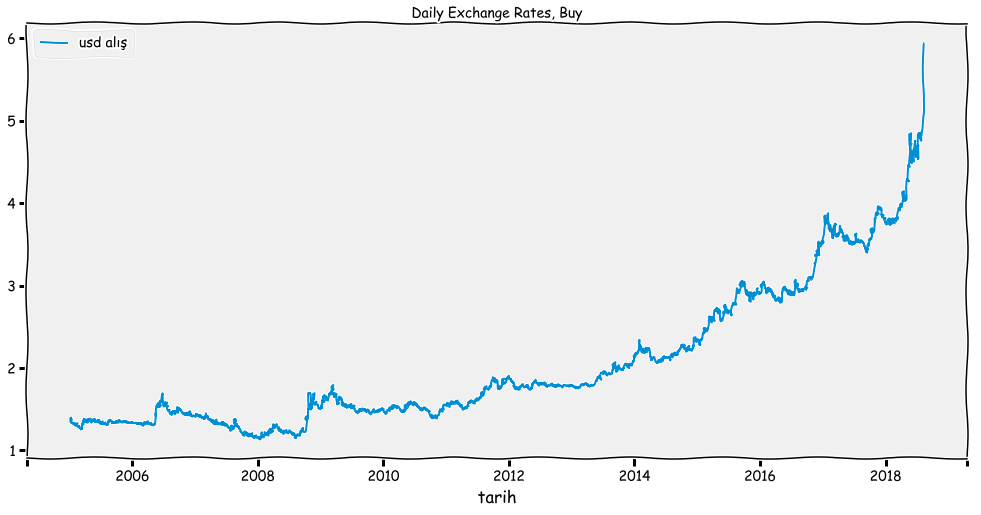

In [11]:
with plt.xkcd():
    fig = plt.figure(figsize=(15,8))
    data.usd_alis.plot(label='usd alış')
    plt.legend(loc='best')
    plt.title('Daily Exchange Rates, Buy', fontsize=14)
    plt.show()

We could also consider de-trending the time series and applying further "cleaning" techniques, which would be a prerequisite e.g. in an *ARIMA* setting.

However, for simplicity reasons we will just proceed with the data as is.

The only transformations we'll be doing are:

* Scale data to the $(0, 1)$ interval for increased numerical stability.
* Re-shape the data so we have one column as **response** (called $Y$ in the code) and another one as **predictor** variable (called $X in the code).

### Building the (Vanilla) LSTM model


In [67]:
# Let's load the required libs.
# We'll be using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Bidirectional, Flatten, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

#### Data preparation

In [13]:
from sklearn.preprocessing import MinMaxScaler
values = data['usd_alis'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(values)

# print a few values
dataset[0:5]

array([[0.0399249 ],
       [0.04034211],
       [0.0412599 ],
       [0.048519  ],
       [0.05321236]], dtype=float32)

#### Split into test / training data

As usual, the data gets split into training and test data so we can later assess how well the final model performs. 

Again, this could be much improved, e.g. using CV and more sophisticated steps to select the "best" model.

In [14]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))


Number of entries (training set, test set): (2982, 1989)


#### Get data into shape to use in Keras

In [15]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [16]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(2980, 1)
New training data shape:
(2980, 1, 1)


#### Build simple LSTM model on training data

The LSTM architecture here consists of:

* One input layer.
* One LSTM layer of 100 blocks.
* One `Dense` layer to produce a single output.
* Use MSE as loss function.

Many different architectures could be considered. But this is just a quick test, so we'll keep things nice and simple.

In [19]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_Y, epochs=300, batch_size=100, validation_data=(test_X, test_Y), verbose=1, shuffle=False)

Train on 2980 samples, validate on 1987 samples
Epoch 1/300
2980/2980 [==============================] - 1s 279us/step - loss: 0.0313 - val_loss: 0.2310
Epoch 2/300
2980/2980 [==============================] - 0s 38us/step - loss: 0.0420 - val_loss: 0.2456
Epoch 3/300
2980/2980 [==============================] - 0s 38us/step - loss: 0.0321 - val_loss: 0.2228
Epoch 4/300
2980/2980 [==============================] - 0s 38us/step - loss: 0.0302 - val_loss: 0.1999
Epoch 5/300
2980/2980 [==============================] - 0s 38us/step - loss: 0.0317 - val_loss: 0.1918
Epoch 6/300
2980/2980 [==============================] - 0s 38us/step - loss: 0.0276 - val_loss: 0.1691
Epoch 7/300
2980/2980 [==============================] - 0s 46us/step - loss: 0.0292 - val_loss: 0.1613
Epoch 8/300
2980/2980 [==============================] - 0s 39us/step - loss: 0.0244 - val_loss: 0.1342
Epoch 9/300
2980/2980 [==============================] - 0s 40us/step - loss: 0.0262 - val_loss: 0.1241
Epoch 10/300
29

2980/2980 [==============================] - 0s 39us/step - loss: 0.0016 - val_loss: 0.0101
Epoch 156/300
2980/2980 [==============================] - 0s 52us/step - loss: 0.0015 - val_loss: 0.0111
Epoch 157/300
2980/2980 [==============================] - 0s 54us/step - loss: 0.0015 - val_loss: 0.0105
Epoch 158/300
2980/2980 [==============================] - 0s 36us/step - loss: 0.0015 - val_loss: 0.0132
Epoch 159/300
2980/2980 [==============================] - 0s 37us/step - loss: 0.0014 - val_loss: 0.0148
Epoch 160/300
2980/2980 [==============================] - 0s 37us/step - loss: 0.0013 - val_loss: 0.0133
Epoch 161/300
2980/2980 [==============================] - 0s 36us/step - loss: 0.0014 - val_loss: 0.0122
Epoch 162/300
2980/2980 [==============================] - 0s 37us/step - loss: 0.0015 - val_loss: 0.0180
Epoch 163/300
2980/2980 [==============================] - 0s 46us/step - loss: 0.0018 - val_loss: 0.0207
Epoch 164/300
2980/2980 [==============================] - 0

### Results
#### Predictions and model evaluation

As can be seen below, already the simple model performs not too poorly. The advantage of using the RMSE is that it's in the same unit as the original data.

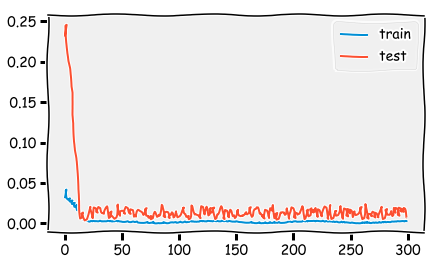

In [20]:
with plt.xkcd():
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

#### Plotting original data, predictions, and forecast

With a plot we can compare the predicted vs. actual exchange rate figures.

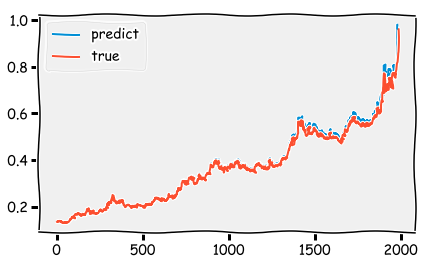

In [21]:
with plt.xkcd():
    yhat = model.predict(test_X)
    plt.plot(yhat, label='predict')
    plt.plot(test_Y, label='true')
    plt.legend()
    plt.show()

Scalar inverse back to normal:

In [22]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
test_Y_inverse = scaler.inverse_transform(test_Y.reshape(-1, 1))

In [23]:
rmse = sqrt(mean_squared_error(test_Y_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.054


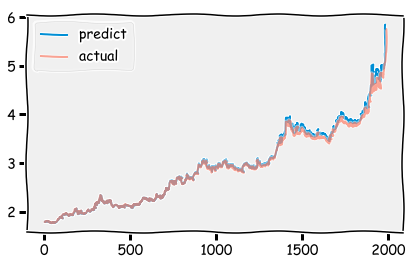

In [24]:
with plt.xkcd():
    plt.plot(yhat_inverse, label='predict')
    plt.plot(test_Y_inverse, label='actual', alpha=0.5)
    plt.legend()
    plt.show()

Convert X to dates:

In [25]:
predictDates = data.tail(len(test_X)).index

Reshape test_Y for plotly:

In [26]:
test_Y_reshape = test_Y_inverse.reshape(len(test_Y_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

Plot predicted values:

In [27]:
actual_chart = go.Scatter(x=predictDates, y=test_Y_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

### Building GRU model

In [29]:
model = Sequential()
model.add(GRU(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_Y, epochs=300, batch_size=100, validation_data=(test_X, test_Y), verbose=1, shuffle=False)

Train on 2980 samples, validate on 1987 samples
Epoch 1/300
2980/2980 [==============================] - 1s 231us/step - loss: 0.0276 - val_loss: 0.2201
Epoch 2/300
2980/2980 [==============================] - 0s 40us/step - loss: 0.0466 - val_loss: 0.2191
Epoch 3/300
2980/2980 [==============================] - 0s 45us/step - loss: 0.0336 - val_loss: 0.1764
Epoch 4/300
2980/2980 [==============================] - 0s 36us/step - loss: 0.0337 - val_loss: 0.1552
Epoch 5/300
2980/2980 [==============================] - 0s 37us/step - loss: 0.0268 - val_loss: 0.1142
Epoch 6/300
2980/2980 [==============================] - 0s 36us/step - loss: 0.0297 - val_loss: 0.1006
Epoch 7/300
2980/2980 [==============================] - 0s 34us/step - loss: 0.0207 - val_loss: 0.0587
Epoch 8/300
2980/2980 [==============================] - 0s 35us/step - loss: 0.0226 - val_loss: 0.0442
Epoch 9/300
2980/2980 [==============================] - 0s 38us/step - loss: 0.0182 - val_loss: 0.0225
Epoch 10/300
29

2980/2980 [==============================] - 0s 38us/step - loss: 0.0020 - val_loss: 0.0026
Epoch 156/300
2980/2980 [==============================] - 0s 37us/step - loss: 0.0019 - val_loss: 0.0032
Epoch 157/300
2980/2980 [==============================] - 0s 35us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 158/300
2980/2980 [==============================] - 0s 41us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 159/300
2980/2980 [==============================] - 0s 37us/step - loss: 0.0017 - val_loss: 0.0026
Epoch 160/300
2980/2980 [==============================] - 0s 38us/step - loss: 0.0017 - val_loss: 0.0080
Epoch 161/300
2980/2980 [==============================] - 0s 35us/step - loss: 0.0028 - val_loss: 0.0025
Epoch 162/300
2980/2980 [==============================] - 0s 37us/step - loss: 0.0019 - val_loss: 0.0083
Epoch 163/300
2980/2980 [==============================] - 0s 36us/step - loss: 0.0019 - val_loss: 0.0111
Epoch 164/300
2980/2980 [==============================] - 0

### Results
#### Predictions and model evaluation

As can be seen below, already the simple model performs not too poorly. The advantage of using the RMSE is that it's in the same unit as the original data.

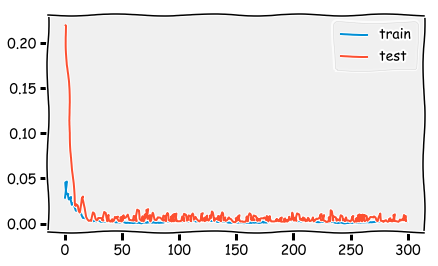

In [30]:
with plt.xkcd():
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

#### Plotting original data, predictions, and forecast

With a plot we can compare the predicted vs. actual exchange rate figures.

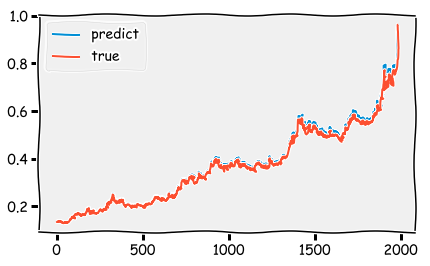

In [31]:
with plt.xkcd():
    yhat = model.predict(test_X)
    plt.plot(yhat, label='predict')
    plt.plot(test_Y, label='true')
    plt.legend()
    plt.show()

Scalar inverse back to normal:

In [32]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
test_Y_inverse = scaler.inverse_transform(test_Y.reshape(-1, 1))

In [33]:
rmse = sqrt(mean_squared_error(test_Y_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.049


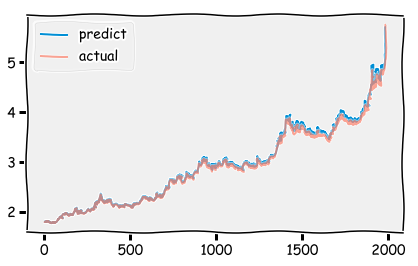

In [34]:
with plt.xkcd():
    plt.plot(yhat_inverse, label='predict')
    plt.plot(test_Y_inverse, label='actual', alpha=0.5)
    plt.legend()
    plt.show()

Convert X to dates:

In [35]:
predictDates = data.tail(len(test_X)).index

Reshape test_Y for plotly:

In [36]:
test_Y_reshape = test_Y_inverse.reshape(len(test_Y_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

Plot predicted values:

In [37]:
actual_chart = go.Scatter(x=predictDates, y=test_Y_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

## Building Bidirectional LSTM model

In [40]:
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_Y, epochs=300, batch_size=100, validation_data=(test_X, test_Y), verbose=1, shuffle=False)

Train on 2980 samples, validate on 1987 samples
Epoch 1/300
2980/2980 [==============================] - 4s 1ms/step - loss: 0.0228 - val_loss: 0.1478
Epoch 2/300
2980/2980 [==============================] - 1s 201us/step - loss: 0.0509 - val_loss: 0.1961
Epoch 3/300
2980/2980 [==============================] - 1s 209us/step - loss: 0.0342 - val_loss: 0.1282
Epoch 4/300
2980/2980 [==============================] - 1s 183us/step - loss: 0.0360 - val_loss: 0.0842
Epoch 5/300
2980/2980 [==============================] - 1s 194us/step - loss: 0.0341 - val_loss: 0.0521
Epoch 6/300
2980/2980 [==============================] - 1s 200us/step - loss: 0.0293 - val_loss: 0.0240
Epoch 7/300
2980/2980 [==============================] - 1s 179us/step - loss: 0.0178 - val_loss: 0.0469
Epoch 8/300
2980/2980 [==============================] - 1s 194us/step - loss: 0.0329 - val_loss: 0.0885
Epoch 9/300
2980/2980 [==============================] - 1s 187us/step - loss: 0.0175 - val_loss: 0.0153
Epoch 10/

Epoch 78/300
2980/2980 [==============================] - 1s 178us/step - loss: 0.0039 - val_loss: 0.0499
Epoch 79/300
2980/2980 [==============================] - 1s 217us/step - loss: 0.0038 - val_loss: 0.0215
Epoch 80/300
2980/2980 [==============================] - 1s 220us/step - loss: 0.0022 - val_loss: 0.0502
Epoch 81/300
2980/2980 [==============================] - 1s 207us/step - loss: 0.0044 - val_loss: 0.0360
Epoch 82/300
2980/2980 [==============================] - 1s 193us/step - loss: 0.0021 - val_loss: 0.0377
Epoch 83/300
2980/2980 [==============================] - 1s 180us/step - loss: 0.0017 - val_loss: 0.0464
Epoch 84/300
2980/2980 [==============================] - 1s 198us/step - loss: 0.0029 - val_loss: 0.0229
Epoch 85/300
2980/2980 [==============================] - 1s 189us/step - loss: 0.0038 - val_loss: 0.0334
Epoch 86/300
2980/2980 [==============================] - 1s 207us/step - loss: 0.0024 - val_loss: 0.0231
Epoch 87/300
2980/2980 [======================

Epoch 155/300
2980/2980 [==============================] - 1s 198us/step - loss: 0.0034 - val_loss: 0.0235
Epoch 156/300
2980/2980 [==============================] - 1s 222us/step - loss: 0.0035 - val_loss: 0.0144
Epoch 157/300
2980/2980 [==============================] - 1s 229us/step - loss: 0.0042 - val_loss: 0.0157
Epoch 158/300
2980/2980 [==============================] - 1s 243us/step - loss: 0.0020 - val_loss: 0.0092
Epoch 159/300
2980/2980 [==============================] - 1s 246us/step - loss: 0.0028 - val_loss: 0.0359
Epoch 160/300
2980/2980 [==============================] - 1s 260us/step - loss: 0.0043 - val_loss: 0.0349
Epoch 161/300
2980/2980 [==============================] - 1s 239us/step - loss: 0.0032 - val_loss: 0.0257
Epoch 162/300
2980/2980 [==============================] - 1s 238us/step - loss: 0.0034 - val_loss: 0.0216
Epoch 163/300
2980/2980 [==============================] - 1s 259us/step - loss: 0.0022 - val_loss: 0.0324
Epoch 164/300
2980/2980 [============

### Results
#### Predictions and model evaluation

As can be seen below, already the simple model performs not too poorly. The advantage of using the RMSE is that it's in the same unit as the original data.

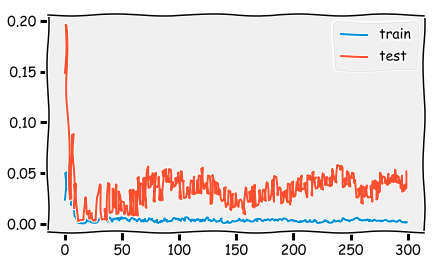

In [41]:
with plt.xkcd():
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

#### Plotting original data, predictions, and forecast

With a plot we can compare the predicted vs. actual exchange rate figures.

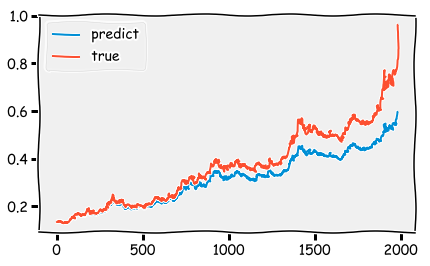

In [42]:
with plt.xkcd():
    yhat = model.predict(test_X)
    plt.plot(yhat, label='predict')
    plt.plot(test_Y, label='true')
    plt.legend()
    plt.show()

Scalar inverse back to normal:

In [43]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
test_Y_inverse = scaler.inverse_transform(test_Y.reshape(-1, 1))

In [44]:
rmse = sqrt(mean_squared_error(test_Y_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.353


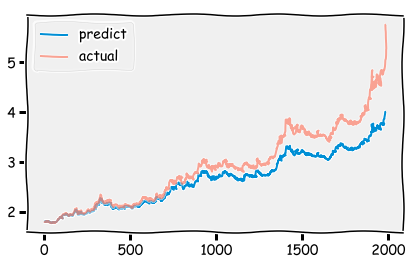

In [45]:
with plt.xkcd():
    plt.plot(yhat_inverse, label='predict')
    plt.plot(test_Y_inverse, label='actual', alpha=0.5)
    plt.legend()
    plt.show()

Convert X to dates:

In [46]:
predictDates = data.tail(len(test_X)).index

Reshape test_Y for plotly:

In [47]:
test_Y_reshape = test_Y_inverse.reshape(len(test_Y_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

Plot predicted values:

In [48]:
actual_chart = go.Scatter(x=predictDates, y=test_Y_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

## A Deeper Network

In [63]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
#model.add(Dropout(0.3))
model.add(Dense(32, kernel_initializer="uniform", activation='relu'))
model.add(Dense(1, kernel_initializer = "uniform", activation='linear'))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_Y, epochs=50, batch_size=100, validation_data=(test_X, test_Y), verbose=1, shuffle=False)

Train on 2980 samples, validate on 1987 samples
Epoch 1/50
2980/2980 [==============================] - 2s 735us/step - loss: 0.0471 - val_loss: 0.2839
Epoch 2/50
2980/2980 [==============================] - 0s 79us/step - loss: 0.0396 - val_loss: 0.2816
Epoch 3/50
2980/2980 [==============================] - 0s 84us/step - loss: 0.0372 - val_loss: 0.2752
Epoch 4/50
2980/2980 [==============================] - 0s 79us/step - loss: 0.0373 - val_loss: 0.2713
Epoch 5/50
2980/2980 [==============================] - 0s 80us/step - loss: 0.0372 - val_loss: 0.2692
Epoch 6/50
2980/2980 [==============================] - 0s 80us/step - loss: 0.0366 - val_loss: 0.2656
Epoch 7/50
2980/2980 [==============================] - 0s 80us/step - loss: 0.0362 - val_loss: 0.2605
Epoch 8/50
2980/2980 [==============================] - 0s 79us/step - loss: 0.0358 - val_loss: 0.2533
Epoch 9/50
2980/2980 [==============================] - 0s 81us/step - loss: 0.0351 - val_loss: 0.2418
Epoch 10/50
2980/2980 [=

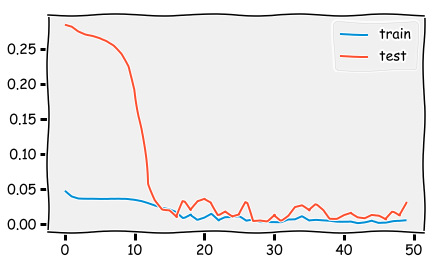

In [65]:
with plt.xkcd():
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [66]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
test_Y_inverse = scaler.inverse_transform(test_Y.reshape(-1, 1))

In [68]:
rmse = sqrt(mean_squared_error(test_Y_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.353


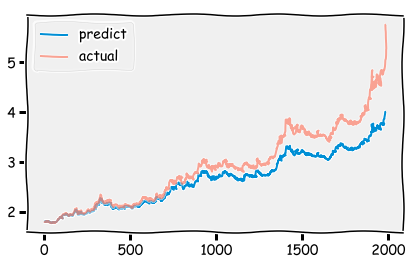

In [69]:
with plt.xkcd():
    plt.plot(yhat_inverse, label='predict')
    plt.plot(test_Y_inverse, label='actual', alpha=0.5)
    plt.legend()
    plt.show()

Convert X to dates:

In [70]:
predictDates = data.tail(len(test_X)).index

Reshape test_Y for plotly:

In [71]:
test_Y_reshape = test_Y_inverse.reshape(len(test_Y_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

Plot predicted values:

In [72]:
actual_chart = go.Scatter(x=predictDates, y=test_Y_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

### Building CNN LSTM model

In [37]:
x_list = data['usd_alis'].tolist()

In [39]:
x_list

[1.3363,
 1.3383,
 1.3427,
 1.3775,
 1.4,
 1.3907666666666667,
 1.3815333333333333,
 1.3723,
 1.3822,
 1.3737,
 1.3732,
 1.35,
 1.3498666666666668,
 1.3497333333333332,
 1.3496,
 1.3317,
 1.3364,
 1.3364,
 1.3364,
 1.3364,
 1.3364,
 1.3364,
 1.3341,
 1.327,
 1.3267,
 1.334,
 1.3322333333333334,
 1.3304666666666667,
 1.3287,
 1.3295,
 1.3252,
 1.3203,
 1.3166,
 1.3148666666666666,
 1.3131333333333333,
 1.3114,
 1.3093,
 1.323,
 1.322,
 1.3327,
 1.3273,
 1.3219,
 1.3165,
 1.3089,
 1.3051,
 1.3063,
 1.305,
 1.3033333333333332,
 1.3016666666666667,
 1.3,
 1.3016,
 1.2927,
 1.298,
 1.2905,
 1.2898333333333334,
 1.2891666666666666,
 1.2885,
 1.2785,
 1.2768,
 1.2772,
 1.271,
 1.2706333333333333,
 1.2702666666666667,
 1.2699,
 1.2541,
 1.2585,
 1.259,
 1.2747,
 1.2694666666666665,
 1.2642333333333333,
 1.259,
 1.276,
 1.2869,
 1.3224,
 1.3174,
 1.3149666666666666,
 1.3125333333333333,
 1.3101,
 1.3297,
 1.329,
 1.358,
 1.3483,
 1.3474333333333333,
 1.3465666666666667,
 1.3457,
 1.3574,
 1.383

In [46]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [53]:
X, y = split_sequence(x_list, n_steps=4)

In [54]:
X

array([[1.3363    , 1.3383    , 1.3427    , 1.3775    ],
       [1.3383    , 1.3427    , 1.3775    , 1.4       ],
       [1.3427    , 1.3775    , 1.4       , 1.39076667],
       ...,
       [5.1464    , 5.2634    , 5.2813    , 5.3988    ],
       [5.2634    , 5.2813    , 5.3988    , 5.57883333],
       [5.2813    , 5.3988    , 5.57883333, 5.75886667]])

In [55]:
X.shape

(4967, 4)

In [56]:
y.shape

(4967,)

In [57]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

In [59]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [61]:
# fit model
model.fit(X, y, epochs=300, verbose=1)

Epoch 1/300
4967/4967 [==============================] - 1s 119us/step - loss: 3.9705e-04
Epoch 2/300
4967/4967 [==============================] - 1s 122us/step - loss: 4.0504e-04
Epoch 3/300
4967/4967 [==============================] - 1s 126us/step - loss: 3.5937e-04
Epoch 4/300
4967/4967 [==============================] - 1s 123us/step - loss: 4.0420e-04
Epoch 5/300
4967/4967 [==============================] - 1s 122us/step - loss: 3.7930e-04
Epoch 6/300
4967/4967 [==============================] - 1s 124us/step - loss: 4.3496e-04
Epoch 7/300
4967/4967 [==============================] - 1s 124us/step - loss: 3.9028e-04
Epoch 8/300
4967/4967 [==============================] - 1s 123us/step - loss: 4.7260e-04
Epoch 9/300
4967/4967 [==============================] - 1s 123us/step - loss: 5.2954e-04
Epoch 10/300
4967/4967 [==============================] - 1s 127us/step - loss: 4.4208e-04
Epoch 11/300
4967/4967 [==============================] - 1s 129us/step - loss: 3.4659e-04
Epoch 12

4967/4967 [==============================] - 1s 130us/step - loss: 4.2864e-04
Epoch 92/300
4967/4967 [==============================] - 1s 137us/step - loss: 3.8597e-04
Epoch 93/300
4967/4967 [==============================] - 1s 120us/step - loss: 4.2264e-04
Epoch 94/300
4967/4967 [==============================] - 1s 122us/step - loss: 3.4807e-04
Epoch 95/300
4967/4967 [==============================] - 1s 118us/step - loss: 3.5520e-04
Epoch 96/300
4967/4967 [==============================] - 1s 126us/step - loss: 4.5519e-04
Epoch 97/300
4967/4967 [==============================] - 1s 121us/step - loss: 3.8411e-04
Epoch 98/300
4967/4967 [==============================] - 1s 140us/step - loss: 3.5957e-04
Epoch 99/300
4967/4967 [==============================] - 1s 131us/step - loss: 3.6692e-04
Epoch 100/300
4967/4967 [==============================] - 1s 116us/step - loss: 4.0080e-04
Epoch 101/300
4967/4967 [==============================] - 1s 113us/step - loss: 3.9263e-04
Epoch 102/

4967/4967 [==============================] - 1s 126us/step - loss: 3.8429e-04
Epoch 181/300
4967/4967 [==============================] - 1s 109us/step - loss: 3.8817e-04
Epoch 182/300
4967/4967 [==============================] - 1s 105us/step - loss: 3.6312e-04
Epoch 183/300
4967/4967 [==============================] - 1s 115us/step - loss: 3.6586e-04
Epoch 184/300
4967/4967 [==============================] - 1s 136us/step - loss: 4.1272e-04
Epoch 185/300
4967/4967 [==============================] - 1s 138us/step - loss: 3.5189e-04
Epoch 186/300
4967/4967 [==============================] - 1s 106us/step - loss: 3.6188e-04
Epoch 187/300
4967/4967 [==============================] - 1s 143us/step - loss: 3.5802e-04
Epoch 188/300
4967/4967 [==============================] - 0s 99us/step - loss: 3.9651e-04
Epoch 189/300
4967/4967 [==============================] - 0s 100us/step - loss: 3.8864e-04
Epoch 190/300
4967/4967 [==============================] - 1s 106us/step - loss: 3.5954e-04
Epo

4967/4967 [==============================] - 0s 96us/step - loss: 3.4323e-04
Epoch 270/300
4967/4967 [==============================] - 1s 101us/step - loss: 3.6335e-04
Epoch 271/300
4967/4967 [==============================] - 0s 96us/step - loss: 3.7432e-04
Epoch 272/300
4967/4967 [==============================] - 1s 122us/step - loss: 3.3958e-04
Epoch 273/300
4967/4967 [==============================] - 1s 158us/step - loss: 3.7248e-04
Epoch 274/300
4967/4967 [==============================] - 1s 153us/step - loss: 3.7729e-04
Epoch 275/300
4967/4967 [==============================] - 1s 118us/step - loss: 3.9072e-04
Epoch 276/300
4967/4967 [==============================] - 1s 119us/step - loss: 3.2507e-04
Epoch 277/300
4967/4967 [==============================] - 1s 113us/step - loss: 3.7067e-04
Epoch 278/300
4967/4967 [==============================] - 1s 111us/step - loss: 3.7060e-04 0s - loss: 
Epoch 279/300
4967/4967 [==============================] - 1s 118us/step - loss: 3.3

In [66]:
# demonstrate prediction
x_input = np.array([5.05 , 5.08, 5.15, 5.27])
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat) # real exchange rate is 5.29

[[5.37932]]


### Building ConvLSTM Model

A type of LSTM related to the CNN-LSTM is the ConvLSTM, where the convolutional reading of input is built directly into each LSTM unit.

The ConvLSTM was developed for reading two-dimensional spatial-temporal data, but can be adapted for use with univariate time series forecasting.

In [68]:
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(x_list, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

In [69]:
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [70]:
# fit model
model.fit(X, y, epochs=300, verbose=1)

Epoch 1/300
4967/4967 [==============================] - 1s 257us/step - loss: 0.9423
Epoch 2/300
4967/4967 [==============================] - 1s 139us/step - loss: 0.0099
Epoch 3/300
4967/4967 [==============================] - 1s 132us/step - loss: 0.0035
Epoch 4/300
4967/4967 [==============================] - 1s 132us/step - loss: 0.0031
Epoch 5/300
4967/4967 [==============================] - 1s 131us/step - loss: 0.0028
Epoch 6/300
4967/4967 [==============================] - 1s 126us/step - loss: 0.0025
Epoch 7/300
4967/4967 [==============================] - 1s 133us/step - loss: 0.0022
Epoch 8/300
4967/4967 [==============================] - 1s 131us/step - loss: 0.0019
Epoch 9/300
4967/4967 [==============================] - 1s 130us/step - loss: 0.0015
Epoch 10/300
4967/4967 [==============================] - 1s 131us/step - loss: 0.0013
Epoch 11/300
4967/4967 [==============================] - 1s 143us/step - loss: 0.0011
Epoch 12/300
4967/4967 [============================

4967/4967 [==============================] - 1s 128us/step - loss: 4.4208e-04
Epoch 92/300
4967/4967 [==============================] - 1s 126us/step - loss: 4.5901e-04
Epoch 93/300
4967/4967 [==============================] - 1s 128us/step - loss: 4.3276e-04
Epoch 94/300
4967/4967 [==============================] - 1s 137us/step - loss: 3.8678e-04
Epoch 95/300
4967/4967 [==============================] - 1s 143us/step - loss: 4.2858e-04
Epoch 96/300
4967/4967 [==============================] - 1s 139us/step - loss: 4.2608e-04
Epoch 97/300
4967/4967 [==============================] - 1s 147us/step - loss: 3.9500e-04
Epoch 98/300
4967/4967 [==============================] - 1s 142us/step - loss: 4.5245e-04
Epoch 99/300
4967/4967 [==============================] - 1s 161us/step - loss: 4.2655e-04
Epoch 100/300
4967/4967 [==============================] - 1s 148us/step - loss: 3.7497e-04
Epoch 101/300
4967/4967 [==============================] - 1s 138us/step - loss: 3.8826e-04
Epoch 102/

Epoch 180/300
4967/4967 [==============================] - 1s 149us/step - loss: 3.4295e-04
Epoch 181/300
4967/4967 [==============================] - 1s 128us/step - loss: 3.4278e-04
Epoch 182/300
4967/4967 [==============================] - 1s 128us/step - loss: 3.0064e-04
Epoch 183/300
4967/4967 [==============================] - 1s 127us/step - loss: 3.1624e-04
Epoch 184/300
4967/4967 [==============================] - 1s 141us/step - loss: 3.3749e-04
Epoch 185/300
4967/4967 [==============================] - 1s 128us/step - loss: 4.0167e-04
Epoch 186/300
4967/4967 [==============================] - 1s 127us/step - loss: 3.5534e-04
Epoch 187/300
4967/4967 [==============================] - 1s 128us/step - loss: 3.1033e-04
Epoch 188/300
4967/4967 [==============================] - 1s 131us/step - loss: 3.1675e-04
Epoch 189/300
4967/4967 [==============================] - 1s 151us/step - loss: 3.0588e-04
Epoch 190/300
4967/4967 [==============================] - 1s 147us/step - loss:

Epoch 269/300
4967/4967 [==============================] - 1s 134us/step - loss: 2.8383e-04
Epoch 270/300
4967/4967 [==============================] - 1s 138us/step - loss: 2.9751e-04
Epoch 271/300
4967/4967 [==============================] - 1s 150us/step - loss: 3.6474e-04
Epoch 272/300
4967/4967 [==============================] - 1s 148us/step - loss: 2.9814e-04
Epoch 273/300
4967/4967 [==============================] - 1s 143us/step - loss: 2.8248e-04
Epoch 274/300
4967/4967 [==============================] - 1s 153us/step - loss: 3.0000e-04
Epoch 275/300
4967/4967 [==============================] - 1s 149us/step - loss: 2.7580e-04
Epoch 276/300
4967/4967 [==============================] - 1s 137us/step - loss: 2.7477e-04
Epoch 277/300
4967/4967 [==============================] - 1s 158us/step - loss: 2.9949e-04
Epoch 278/300
4967/4967 [==============================] - 1s 135us/step - loss: 3.5542e-04
Epoch 279/300
4967/4967 [==============================] - 1s 143us/step - loss:

In [72]:
# demonstrate prediction
x_input = np.array([5.05 , 5.08, 5.15, 5.27])
x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat) # real exchange rate is 5.29

[[5.3037996]]


### Next steps and things to explore

* Work with de-trended, stationary time series. Does it improve performance?
* Different window size (multiple regression).
* LSTM architecture, i.e. more layers, neurons etc.
* Impact of various hyperparameters in LSTM network on prediction accuracy.
* Model selection steps to find the "best" model.
* Multivariate predictions.

## References and links

* A good reference summary cards:  https://www.slideshare.net/TessFerrandez/notes-from-coursera-deep-learning-courses-by-andrew-ng
* A good dive into deep learning: http://en.diveintodeeplearning.org/
* Another great post: https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f
* Example 2 code adapted from the above: https://github.com/kmsravindra/ML-AI-experiments/tree/master/AI/LSTM-time_series
* Good paper comparing different time series modeling techniques, including LSTM: https://arxiv.org/pdf/1705.09137.pdf
* Another excellent paper: https://arxiv.org/pdf/1705.05690.pdf
* Brilliant LSTM course by Nando de Freitas: https://www.youtube.com/watch?v=56TYLaQN4N8
* A good visual understanding of Recurrent Neural Networks: http://colah.github.io/posts/2015-08-Understanding-LSTMs/